In [10]:
# from Decoder_Transformer import DecoderTransformerWrapper as dtw
import torch
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

In [11]:
class ReverseDataset(Dataset):
    def __init__(self, length):
        self.length = length
        self.size = 10**length # total number of possible combinations

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        x = torch.randint(10, size=(self.length,), dtype=torch.long)
        y = torch.flip(x,(-1,))
        return x, y

In [12]:
rd = ReverseDataset(6)

batch_size = 2048
train_loader = DataLoader(
    rd, shuffle=True, pin_memory=True, batch_size=batch_size
)
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [95]:
class transformer_vocab():
    def __init__(self, vocab):
        """Takes a list of unique words in vocab"""
        self.vocab = vocab
        self.indextoword = {i : word for i, word in enumerate(self.vocab)}
        self.wordtoindex = {word: i for i, word in enumerate(self.vocab)} 

    def human_readable(self, l):
        return [self.indextoword[i.item()] for i in l]

    def machine_readable(self, l):
        return [self.wordtoindex[i] for i in l]

class transformer_trace():
    def __init__(self, embeddings, attn, input, logits, vocab: transformer_vocab):
        self.embeddings = embeddings
        self.attn = attn
        self.input = input.cpu()
        self.logits = logits.cpu()
        self.vocab = vocab

    def human_readable_input(self):
        return [self.vocab.indextoword[i.item()] for i in self.input]

    def get_attn(self, layer, head):
        return self.attn[f'Layer {layer}'][0][head].cpu()

    def plot_attn(self, layer, head):
        plt.imshow(self.get_attn(layer=layer, head=head), interpolation='nearest')
        plt.ylabel("Attention from")
        plt.xlabel("Attention to")
        plt.xticks(range(len(self.input)), self.vocab.human_readable(self.input))
        plt.yticks(range(len(self.input)), self.vocab.human_readable(self.input))
        plt.show()

    def get_embeddings(self, layer):
        return self.embeddings[f'Layer {layer}'][0].cpu()

    def plot_embeddings(self, layer):
        plt.imshow(self.get_embeddings(layer=layer), interpolation='nearest')
        plt.ylabel("Sequence position")
        plt.xlabel("Token")
        plt.xticks(range(len(self.vocab.vocab)), self.vocab.vocab)
        plt.yticks(range(len(self.input)))
        plt.show()

    def top_k_logits(self, k):
        v, ix = torch.topk(self.logits, k, dim=-1)
        out = self.logits.clone()
        out[out < v] = -float('Inf')
        self.logits = out
        return self

    def sample(self):
        # apply softmax to convert to probabilities
        probs = self.logits[0].softmax(dim=-1)
        # sample from the distribution or take the most likely
        ix = torch.multinomial(probs, num_samples=1)
        return([self.vocab.indextoword[i.item()] for i in ix])

    def __str__(self):
        " ".join(self.human_readable_input())

### Transformer

In [75]:
import torch
import torch.nn as nn
from torch import optim
import math, copy
from tqdm import tqdm

class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        torch.zeros(d_model)
        
        encodings = torch.zeros(max_len, d_model)
        dimensions = torch.arange(d_model)
        denominator = div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        positions = torch.arange(max_len).unsqueeze(1)
        encodings[:,0::2] = torch.sin(positions * denominator)
        encodings[:,1::2] = torch.cos(positions * denominator)
        self.register_buffer('encodings', encodings) #Registers a persistent buffer for this layer
        
    def forward(self, x):
        #x; batch_size, seq_length, d_model
        x = x + self.get_buffer('encodings')[:x.size(-2)]
        return self.dropout(x)

def attention(Q, K, V, mask=None, dropout=None):
    #Q, K, V; batch_size, h, seq_length, dk or dv
    rt_d_k = math.sqrt(Q.size(-1))
    scores = torch.matmul(Q, K.transpose(-1,-2)) / rt_d_k
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -math.inf)
        
    p_att = scores.softmax(dim=-1)
    size = V.size()
    if dropout is not None:
        p_att = dropout(p_att)
    
    return torch.matmul(p_att, V), p_att

class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.1, h = 8, mask=None):
        super(MultiHeadedAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.h = h
        self.dk = d_model // h
        self.dv = self.dk
        self.attn = None
        self.mask = mask
        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)
        self.W0 = nn.Linear(d_model, d_model)
        
    
    def forward(self, x, mask=None):
        # x; batch_size, seq_length, d_model
        batch_size = x.size(0)
        
        #Linearly project X into Q, K, and V
        queries = self.WQ(x) #batch_size, seq_length, d_model
        keys = self.WK(x)    #batch_size, seq_length, d_model
        values = self.WV(x)  #batch_size, seq_length, d_model
        
        #Split Q, K, and V into multi headed
        queries = queries.view(batch_size, -1, self.h, self.dk).transpose(1,2)
        keys = keys.view(batch_size, -1, self.h, self.dk).transpose(1,2)
        values = values.view(batch_size, -1, self.h, self.dv).transpose(1,2)
        
        #q,k,v ; batch_size, h, seq_length, (dk or dv)
        
        x, self.attn = attention(queries, keys, values, mask, self.dropout)
        #x; batch_size, h, seq_length, dk
        #self.attn; batch_size, 
        
        x = x.transpose(1,2).contiguous().view(batch_size, -1, self.dk * self.h)
        #x; batch_size, seq_length, model_size
        
        return self.W0(x)

class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super(FeedForwardNetwork, self).__init__()
        self.seq = nn.Sequential(nn.Linear(d_model, d_ff),
                                 nn.ReLU(), 
                                 nn.Dropout(dropout),
                                 nn.Linear(d_ff, d_model))
    
    def forward(self, x):
        return self.seq(x)

class DecoderBlock(nn.Module):
    def __init__(self, d_model, hidden_layers=2048, dropout=0.1, h=8):
        super(DecoderBlock, self).__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadedAttention(d_model, dropout, h)
        self.ffn = FeedForwardNetwork(d_model, hidden_layers, dropout)
        
        
    def forward(self, x, mask=None):
        base_mask = torch.tril(torch.ones(x.size(-2), x.size(-2))).to(x.device)
        if mask is not None:
            base_mask = mask*base_mask
        x = self.ln1(x + self.mha(x, base_mask))
        x = self.ln2(x + self.ffn(x))
        return x

class DecoderStack(nn.Module):
    def __init__(self, d_model, N=8, hidden_layers=2048, dropout=0.1, h=8):
        super(DecoderStack, self).__init__()
        self.decoder_blocks = nn.ModuleList([copy.deepcopy(DecoderBlock(d_model, hidden_layers, dropout, h)) for x in range(N)])
    
    def forward(self, x, mask=None):
        for block in self.decoder_blocks:
            x = block(x, mask)
        return x


class DecoderTransformer(nn.Module):
    def __init__(self, d_model, vocab, N=8, d_ffl=2048, dropout=0.1, h=8, max_len=5000):
        super(DecoderTransformer, self).__init__()
        assert d_model % h == 0
        self.learned_embeddings = nn.Embedding(vocab, d_model)
        self.positional_embedding = PositionalEmbedding(d_model, dropout=dropout, max_len=max_len)
        self.decoder_stack = DecoderStack(d_model, N=N, hidden_layers=d_ffl, dropout=dropout, h=h)
        self.lin = nn.Linear(d_model, vocab)
    
    
    def forward(self, x, mask=None):
        #x; batch_size, seq_length, vocab_len
        embedding = self.learned_embeddings(x) #batch_size, seq_length, d_model
        pos_embedding = self.positional_embedding(embedding) #batch_size, seq_length, d_model
        final_embedding = self.decoder_stack(pos_embedding) #batch_size, seq_length, d_model
        logits = self.lin(final_embedding) #.softmax(dim=-1) #batch_size, seq_length, vocab_len
        return logits
        
import torch
import torch.nn as nn
from torch import optim
import math, copy
from tqdm import tqdm

class DecoderTransformerHandler():
    def __init__(self, model, vocab):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.decoder_transformer = model.to(self.device)
        self.losses = []
        self.vocab = vocab

    @classmethod
    def from_parameters(cls, d_model, vocab, d_ffl=None, height=4, heads=8, dropout=0.1, max_len=5000):
        #vocab should be a list of allowed values
        if d_ffl is None:
            d_ffl = d_model * 4
        model = DecoderTransformer(
          d_model=d_model, 
          vocab=len(vocab.vocab), 
          N=height,
          d_ffl=d_ffl, 
          dropout=dropout, 
          h=heads,
          max_len=max_len
        )
        return cls(model, vocab)

    def train(self, train_loader, lr=1e-4, max_epochs=1, loss_fn=nn.CrossEntropyLoss(), test_lambda=None):
        self.decoder_transformer.train()
        optimizer = optim.Adam(self.decoder_transformer.parameters(), lr=lr)
        self.losses = []
        for epoch in range(max_epochs):
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for it, (x, y) in pbar:
                x = x.to(self.device)
                y = y.to(self.device)

                optimizer.zero_grad()

                logits = self.decoder_transformer(x)
                loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
                loss.backward()
                self.losses.append(loss.cpu().detach().numpy())

                pred = logits.argmax(dim=-1)
                if test_lambda is None:
                    correct = (pred == y).type(torch.float).sum().item()
                else:
                    correct = test_lambda(pred, y).type(torch.float).sum().item()
                accuracy = correct / x.size(0)
                optimizer.step()
                pbar.set_description(f"epoch {epoch} iter {it}: train loss {loss.item():.5f}, accuracy {accuracy*100:0.2f}%")
  
    def test(self, test_loader, test_lambda=None):
        self.decoder_transformer.eval()
        correct = 0
        n = 0
        with torch.no_grad():
            pbar = tqdm(enumerate(test_loader), total=len(test_loader))
            for it, (x, y) in pbar:
                x = x.to(self.device)
                y = y.to(self.device)
                n += x.size(0)
                logits = self.decoder_transformer(x)
                pred = logits.argmax(dim=-1)
                if test_lambda is None:
                    correct += (pred == y).type(torch.float).sum().item()
                else:
                    correct += test_lambda(pred, y).type(torch.float).sum().item()
                accuracy = correct / n
                pbar.set_description(f"iter {it}: test accuracy {accuracy*100:.2f}%")    
    
    def __call__(self, x):
        self.decoder_transformer.eval()
        x = x.to(self.device)
        if len(x.size()) == 1:
            x = x.unsqueeze(0)
        with torch.no_grad():
            logits = self.decoder_transformer(x)
        return logits
    
    def interpreted_trace(self, tokens):
        """tokens is a sentence of tokens"""
        x = torch.tensor([self.vocab.wordtoindex[token] for token in tokens])
        embeddings = {}
        attn = {}
        def get_features(name):
            def hook(model, input, output):
                tokens[name] = handler.decoder_transformer.lin(output.detach())
                attn[name] = model.mha.attn.detach()
            return hook
        handles = [self.decoder_transformer.decoder_stack.decoder_blocks[i].register_forward_hook(get_features(f'Layer {i}')) for i in range(len(self.decoder_transformer.decoder_stack.decoder_blocks))]

        logits = self(x)
        for h in handles:
            h.remove()
        
        return transformer_trace(embeddings, attn, x, logits, self.vocab)

    def to(self, device):
        self.device = device
        self.decoder_transformer.to(device)

### Experimenting

In [76]:
handler = DecoderTransformerHandler.from_parameters(d_model=128,
                                    vocab=transformer_vocab(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']),
                                    height=1,
                                    d_ffl=512, 
                                    dropout=0.1, 
                                    heads=2)
handler.train(train_loader, test_lambda=lambda pred, y: (pred == y)[:, -3:].all(dim=-1))

epoch 0 iter 488: train loss 1.46381, accuracy 46.01%: 100%|██████████| 489/489 [00:22<00:00, 22.06it/s]


In [73]:
handler = DecoderTransformerHandler(handler.decoder_transformer, transformer_vocab(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']))

In [93]:
trace = handler.interpreted_trace(['a','b','c','d','e','f'])

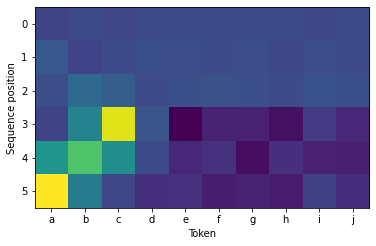

In [94]:
trace.plot_embeddings(0)

In [98]:
from bertviz import head_view, model_view
from bertviz.neuron_view import show

In [101]:
attention = trace.attn['Layer 0']
tokens = trace.get_embeddings(0)
input = trace.vocab.human_readable(trace.input)
head_view((attention,), input)

<IPython.core.display.Javascript object>

In [96]:
trace.sample()

['d', 'd', 'b', 'c', 'b', 'a']

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model
import torch

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [6]:
print("hello")

hello
